In [1]:
import numpy as np
import random
import os

#   Plotting
import seaborn as sns
import matplotlib.pyplot as plt


#   DataGenerator to read images and rescale images
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
import tensorflow_addons as tfa

#   count each class samples
from collections import Counter

#   callbacks
from tensorflow.keras.callbacks import ReduceLROnPlateau

#   evaluate precison recall and f1-score of each class of sequential_model
from sklearn.metrics import classification_report
#   Show performance of a classification sequential_model
from sklearn.metrics import confusion_matrix

#   Different layers
from keras.models import Sequential, Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Convolution2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import ReLU
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Softmax
from tensorflow.keras.layers import Concatenate

# Visualizing Model
from tensorflow.keras.utils import plot_model

# split dataset to train, validation and test set
from sklearn.model_selection import train_test_split

#   callbacks
from keras import callbacks

# Modules for handling class imbalance
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.over_sampling import ADASYN, SMOTE, BorderlineSMOTE
from sklearn.utils import shuffle


#   Optimizer
from tensorflow.keras.optimizers import SGD

from sklearn.metrics import roc_curve, auc
from itertools import cycle

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
WORKING_DIRECTORY = '/kaggle/input/adni-alzheimers-5-class-combined/AD-5-Class'
CLASSES = ['EMCI', 'LMCI', 'MCI', 'AD', 'CN']

In [3]:
X, y = [], []
height, width = 176, 176
# Images rescaling
datagen = ImageDataGenerator(rescale=1.0/255.0)
# print(datagen)

#   Load images all at once by resizing and shuffling randomly
train_dataset = datagen.flow_from_directory(WORKING_DIRECTORY, target_size=(height, width),batch_size=6400, shuffle=True)
# print(train_dataset[0])

# Seperate dataset from  Data Generator into data and labels
X, y = train_dataset.next()

Found 1296 images belonging to 5 classes.


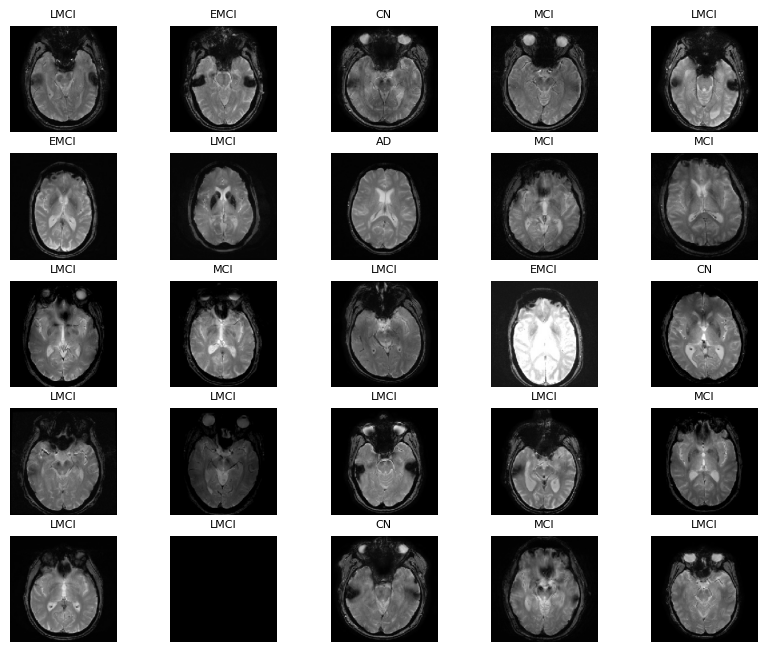

In [4]:
fig = plt.figure(figsize=(10,8))

rows = 5
columns = 5

for i in range(rows * columns):
    fig.add_subplot(rows, columns, i+1)
    num = random.randint(0, len(X)-1 )
    plt.imshow(X[num])
    plt.axis('off')
    plt.title(CLASSES[(np.argmax(y[num]))], fontsize=8)
plt.axis('off')
plt.show()

In [5]:
samples_before = len(X)
print("Images shape :\t", X.shape)
print("Labels shape :\t", y.shape)

Images shape :	 (1296, 176, 176, 3)
Labels shape :	 (1296, 5)


In [6]:
class_samples = sorted(Counter(np.argmax(y, axis=1)).items())
type(class_samples)

list

In [7]:
# Extract the first elements into a separate list
labels = ['EMCI', 'LMCI', 'MCI', 'AD', 'CN']

# Extract the second elements into another list
counts = [t[1] for t in class_samples]

print(labels)
print(counts)

['EMCI', 'LMCI', 'MCI', 'AD', 'CN']
[171, 580, 240, 72, 233]


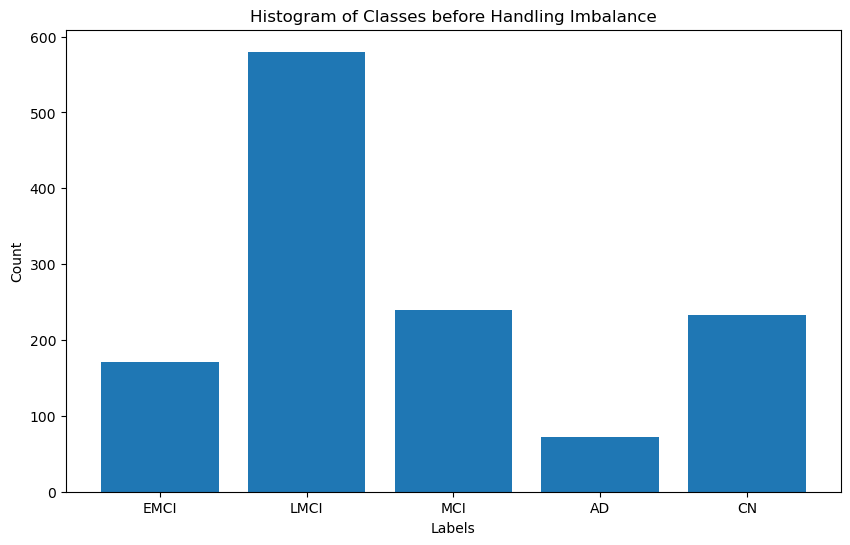

In [8]:
plt.figure(figsize=(10, 6))
# Create a histogram plot
plt.bar(labels, counts)
plt.xticks(labels)

# Add labels and title to the plot
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Histogram of Classes before Handling Imbalance')

# Display the plot
plt.show()

In [9]:
from imblearn.over_sampling import SMOTE, SMOTENC, BorderlineSMOTE
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.over_sampling import ADASYN

def balance_classes(X, y, technique):
    if technique == 'smote':
        oversampler = SMOTE(random_state=42)
    elif technique == 'smotetomek':
        oversampler = SMOTETomek(random_state=42)
    elif technique == 'smoteenn':
        oversampler = SMOTEENN(random_state=42)
    elif technique == 'adasyn':
        oversampler = ADASYN(random_state=42)
    elif technique == 'borderlinesmote':
        oversampler = BorderlineSMOTE(random_state=42)
    else:
        raise ValueError(f"Unsupported oversampling technique: {technique}")
    
    # Apply the selected oversampling technique
    X_resampled, y_resampled = oversampler.fit_resample(X, y)
    
    # Return the balanced datasets
    return X_resampled, y_resampled

In [10]:
num_samples, width, height, channels = X.shape
flattened_shape = width * height * channels

X = X.reshape(-1, flattened_shape)

In [11]:
X, y = balance_classes(X, y, 'smotetomek')

In [12]:
X = X.reshape(-1, width, height, channels)

In [13]:
print("Number of samples after removing class imbalance :\t", sorted(Counter(np.argmax(y, axis=1)).items()))

Number of samples after removing class imbalance :	 [(0, 580), (1, 579), (2, 579), (3, 580), (4, 580)]


In [14]:
class_samples = sorted(Counter(np.argmax(y, axis=1)).items())
# Extract the labels into a separate list
labels = [t[0] for t in class_samples]

# Extract the sample counts  into another list
counts = [t[1] for t in class_samples]

print(labels)
print(counts)

[0, 1, 2, 3, 4]
[580, 579, 579, 580, 580]


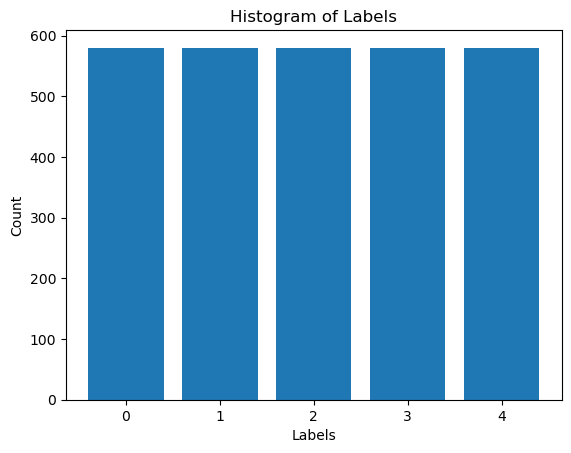

In [15]:
# Create a histogram plot
plt.bar(labels, counts)

# Add labels and title to the plot
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Histogram of Labels')

# Display the plot
plt.show()

## Train test validation split

In [16]:
# Data shuffled while loaded so no shuffling is done while splitting data.
# 80% training data, 20 % validation data
X_train, x_val, y_train, y_val = train_test_split(X, y, test_size = 0.2 )

# Out of 80% training data, 20 % are taken as test data, remaining 60 % will serve as training data
X_train, x_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.2 )

In [17]:
del X,y

In [18]:
# Number of samples after train test split
print("Number of samples after splitting into Training, validation & test set\n")

print("Train     \t",sorted(Counter(np.argmax(y_train, axis=1)).items()))
print("Validation\t",sorted(Counter(np.argmax(y_val, axis=1)).items()))
print("Test      \t",sorted(Counter(np.argmax(y_test, axis=1)).items()))

Number of samples after splitting into Training, validation & test set

Train     	 [(0, 392), (1, 360), (2, 356), (3, 382), (4, 364)]
Validation	 [(0, 118), (1, 115), (2, 111), (3, 112), (4, 124)]
Test      	 [(0, 70), (1, 104), (2, 112), (3, 86), (4, 92)]


## Create the Model

In [19]:
from keras.initializers import GlorotUniformV2
init = GlorotUniformV2

In [20]:
def create_feature_extractor(shared_input_layer, kernel_size):
    x = shared_input_layer
    units = [16, 32, 64, 128, 256]  # No. of units of 4 convolution blocks
    for unit in units:
        x = Convolution2D(unit, kernel_size=kernel_size, kernel_initializer=init, padding='same')(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = LeakyReLU()(x)
    x = Dropout(0.2)(x)
    return x

In [21]:
# Define the input layer shared by both feature extractors
input_layer = Input(shape=(176, 176, 3))

In [22]:
#Create feature extractors that share the input layer

# Create the first feature extractor with kernel size 5, used to extract local features
feature_extractor1 = create_feature_extractor(input_layer, kernel_size=(3, 3))

# Create the second feature extractor with kernel size 12, used to extract local features
feature_extractor2 = create_feature_extractor(input_layer, kernel_size=(11, 11))

In [23]:
# Combine their output
merged_feature_extractors = Concatenate()([feature_extractor1, feature_extractor2])

In [24]:
# Define rest of ADD-Net architecture
flatten_layer = Flatten()(merged_feature_extractors)
dense_layer1 = Dense(256, kernel_initializer=init)(flatten_layer)
activation_layer = LeakyReLU()(dense_layer1)
dropout_layer = Dropout(0.3)(activation_layer)
dense_layer2 = Dense(5,kernel_initializer=init)(dropout_layer)
output_layer = Softmax()(dense_layer2)

In [25]:
model = Model(inputs = input_layer, outputs = output_layer)

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 176, 176, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 176, 176, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_5 (Conv2D)              (None, 176, 176, 16  5824        ['input_1[0][0]']                
                                )                                                             

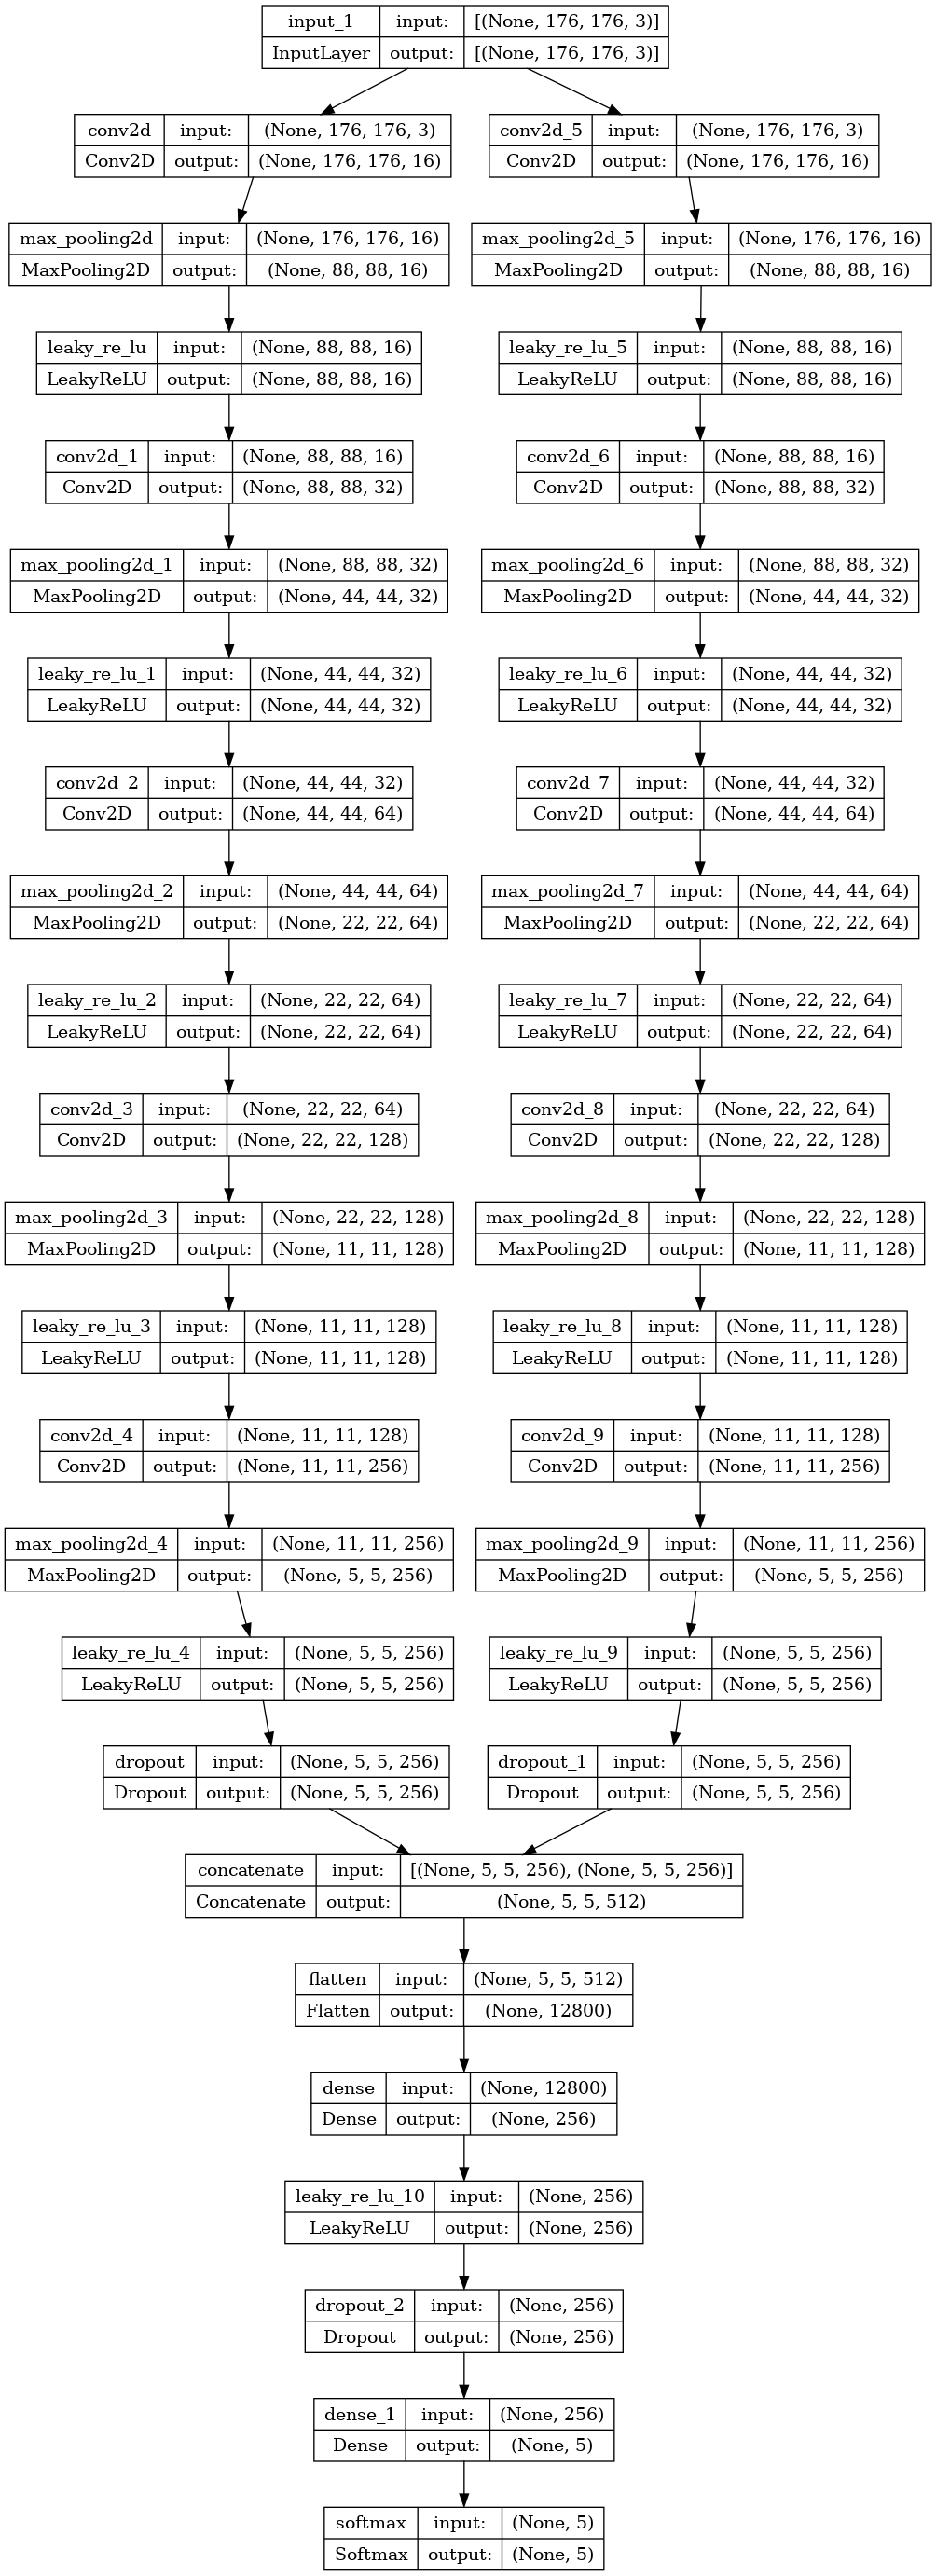

In [26]:
# plot graph
plot_model(model, to_file='shared_input_layer.png', show_shapes=True)

In [27]:
print(type(model))

<class 'keras.engine.functional.Functional'>


## Set Parameters for Training the Model

In [28]:
model.compile(
    optimizer=SGD(learning_rate=0.01), 
    loss = tf.keras.losses.CategoricalCrossentropy(name='loss'), 
    metrics=[
        tf.keras.metrics.CategoricalAccuracy(name='acc'), 
        tf.keras.metrics.AUC(name='auc'),
        tfa.metrics.F1Score(num_classes=5),
        tf.metrics.Precision(name="precision"),
        tf.metrics.Recall(name="recall") ])

In [29]:
# callbacks used in sequential_model to perform well
rop_callback = ReduceLROnPlateau(monitor="val_loss", patience=2)

CALLBACKS = [rop_callback]

In [30]:
#   declare to run on small gpu create batch sizes of images
valAug = ImageDataGenerator()

#   defining batch size
batch_size = 8
history = model.fit(valAug.flow(X_train, y_train, batch_size=batch_size, shuffle = True),
steps_per_epoch=len(X_train) // batch_size,
validation_data=valAug.flow(x_val, y_val, batch_size=batch_size, shuffle = True),
validation_steps=len(x_test) // batch_size,
epochs= 60,
batch_size=batch_size,
callbacks = CALLBACKS
)

Epoch 1/60


2023-08-11 18:54:52.213507: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


231/231 [==============================] - 27s 43ms/step - loss: 1.6105 - acc: 0.2004 - auc: 0.5080 - f1_score: 0.1754 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.6043 - val_acc: 0.2241 - val_auc: 0.5377 - val_f1_score: 0.1180 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0100
Epoch 2/60
231/231 [==============================] - 8s 36ms/step - loss: 1.6039 - acc: 0.2264 - auc: 0.5390 - f1_score: 0.1707 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.6008 - val_acc: 0.2134 - val_auc: 0.5726 - val_f1_score: 0.1110 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0100
Epoch 3/60
231/231 [==============================] - 8s 36ms/step - loss: 1.5960 - acc: 0.2519 - auc: 0.5624 - f1_score: 0.2199 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.5868 - val_acc: 0.2694 - val_auc: 0.5920 - val_f1_score: 0.1813 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0100
Epoch 4/60
231/231 [==============================] - 8s

In [31]:
### Evaluate sequential_model
test_scores = model.evaluate(x_test, y_test, batch_size = 32)


print("\n\nTesting Loss : \t\t {0:0.6f}".format(test_scores[0] ))
print("Testing Accuracy : \t {0:0.6f} %".format(test_scores[1] * 100))
print("Testing AC : \t\t {0:0.6f} %".format(test_scores[2] * 100))
print("Testing F1-Score : \t {0:0.6f} %".format(((test_scores[3][0] + test_scores[3][1] + test_scores[3][2] + test_scores[3][3])/4) * 100))
print("Testing Precision : \t {0:0.6f} %".format(test_scores[4] * 100))
print("Testing Recall : \t {0:0.6f} %".format(test_scores[5] * 100))

15/15 [==============================] - 2s 75ms/step - loss: nan - acc: 0.1509 - auc: 0.5000 - f1_score: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00


Testing Loss : 		 nan
Testing Accuracy : 	 15.086207 %
Testing AC : 		 50.000000 %
Testing F1-Score : 	 0.000000 %
Testing Precision : 	 0.000000 %
Testing Recall : 	 0.000000 %


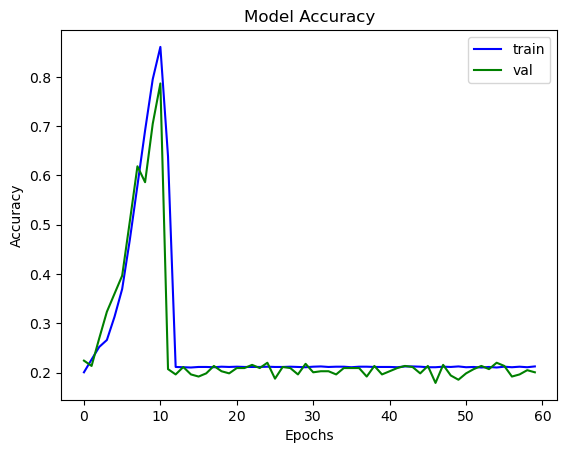

In [32]:
plt.plot(history.history['acc'], 'b')
plt.plot(history.history['val_acc'], 'g')
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["train", "val"])
plt.show()

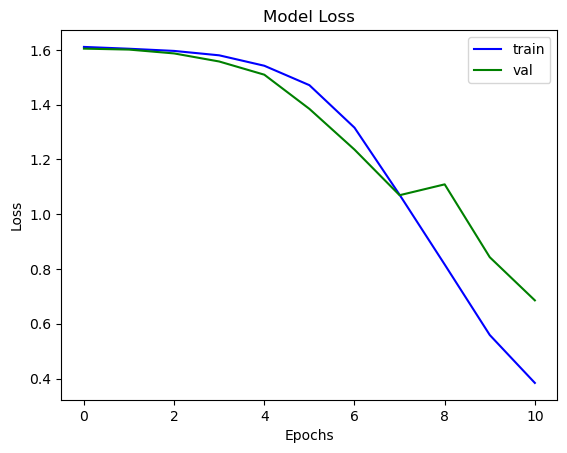

In [33]:
plt.plot(history.history['loss'], 'b')
plt.plot(history.history['val_loss'], 'g')
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["train", "val"])
plt.show()

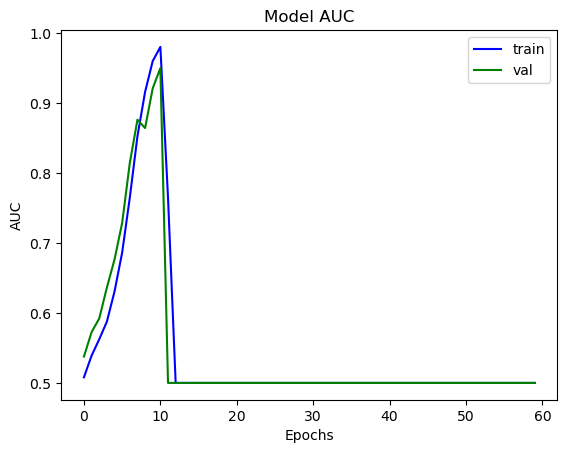

In [34]:
plt.plot(history.history['auc'], 'b')
plt.plot(history.history['val_auc'], 'g')
plt.title("Model AUC")
plt.xlabel("Epochs")
plt.ylabel("AUC")
plt.legend(["train", "val"])
plt.show()

In [35]:
pred_labels = model.predict(x_test, batch_size=32)

def roundoff(arr):
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels:
    labels = roundoff(labels)

print(classification_report(y_test, pred_labels, target_names=CLASSES))

15/15 [==============================] - 1s 26ms/step
              precision    recall  f1-score   support

        EMCI       0.15      1.00      0.26        70
        LMCI       0.22      1.00      0.37       104
         MCI       0.24      1.00      0.39       112
          AD       0.19      1.00      0.31        86
          CN       0.20      1.00      0.33        92

   micro avg       0.20      1.00      0.33       464
   macro avg       0.20      1.00      0.33       464
weighted avg       0.20      1.00      0.34       464
 samples avg       0.20      1.00      0.33       464



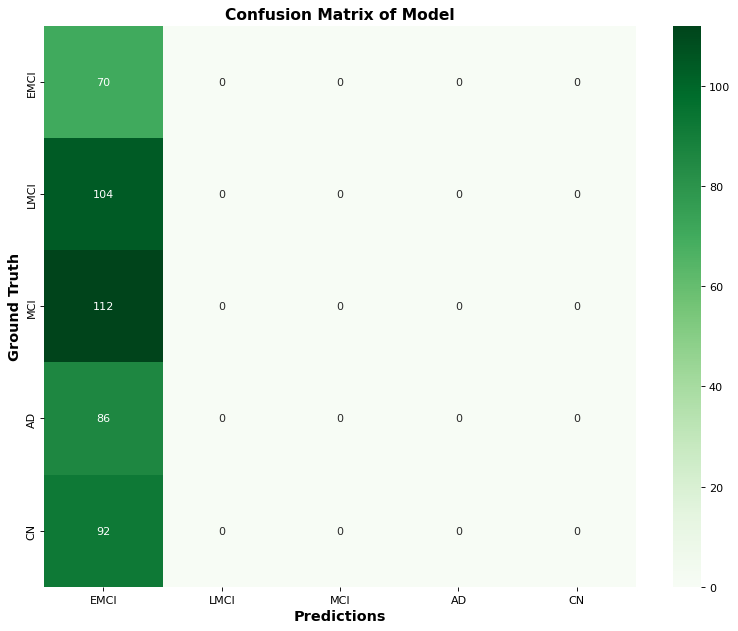

In [36]:
pred_ls = np.argmax(pred_labels, axis=1)
test_ls = np.argmax(y_test, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels= CLASSES, yticklabels=CLASSES)

plt.title('Confusion Matrix of Model', fontweight='bold', fontsize=14.0)
plt.xlabel('Predictions', fontweight='bold', fontsize=13)
plt.ylabel('Ground Truth', fontweight='bold', fontsize=13)
plt.tight_layout()
plt.show(ax)

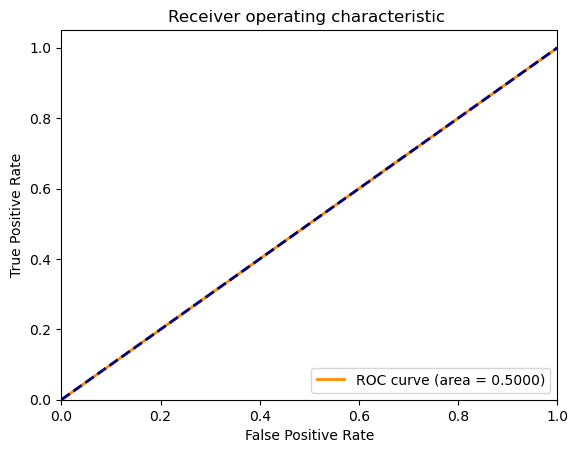

In [37]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], pred_labels[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), pred_labels.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(
    fpr[2],
    tpr[2],
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.4f)" % roc_auc[2])

plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic ")
plt.legend(loc="lower right")
plt.show()

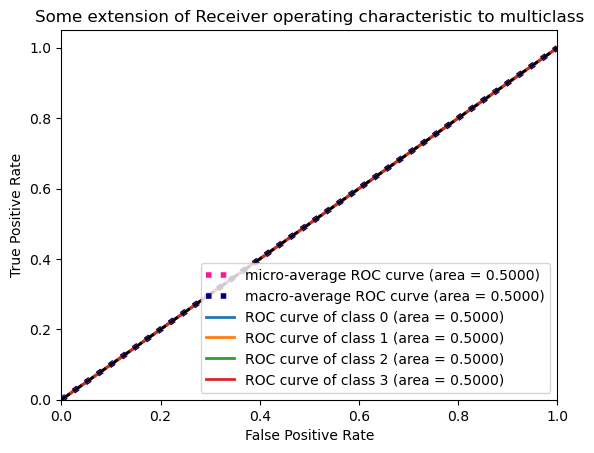

In [38]:
n_classes = 4
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.4f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.4f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

for i in range(n_classes):
    plt.plot(
        fpr[i],
        tpr[i],
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.4f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()